In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Compliance: "Assess data quality" requires checking confidence levels
sns.set_theme(style="whitegrid")

# 1. Load Data
try:
    df = pd.read_csv('../data/processed/ethiopia_fi_enriched.csv')
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    print(f"✅ Data Loaded: {len(df)} rows")
except FileNotFoundError:
    print("❌ Error: Run this from the project root.")

✅ Data Loaded: 51 rows


--- DATA INVENTORY ---

1. Records by Type:
record_type
observation    35
event          13
target          3
Name: count, dtype: int64

2. Records by Pillar (Observations Only):
pillar
ACCESS           14
USAGE            14
GENDER            4
AFFORDABILITY     3
Name: count, dtype: int64

3. Data Quality (Confidence Levels):
confidence
high      40
High       6
medium     3
Medium     2
Name: count, dtype: int64


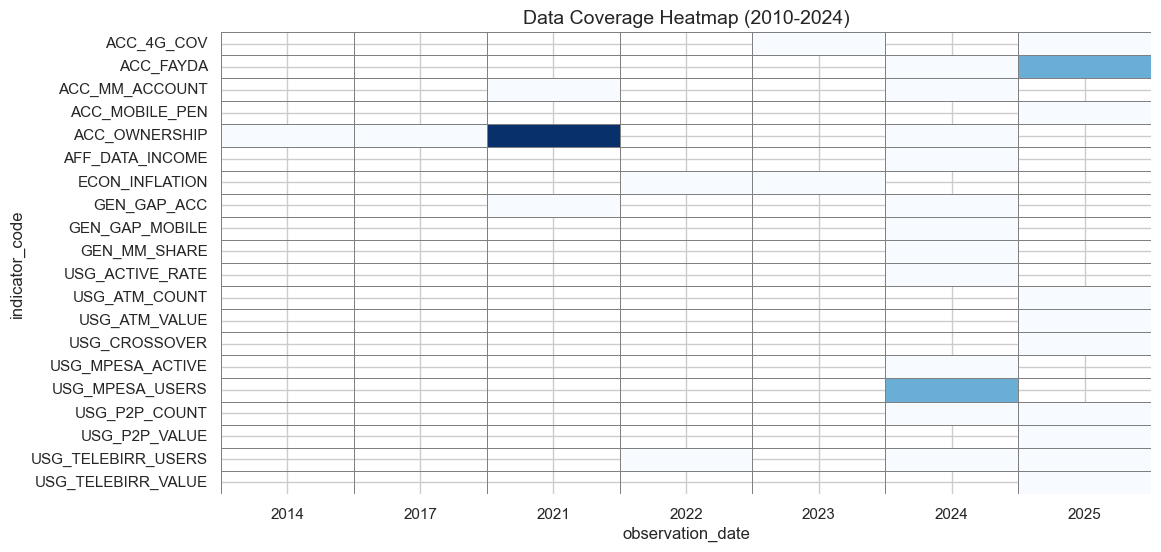

DATA GAP IDENTIFIED: Note the white space between 2021-2024 for non-proxy indicators.


In [3]:
# --- 1. Dataset Overview & Quality ---

print("--- DATA INVENTORY ---")
# Summarize by key dimensions
print("\n1. Records by Type:")
print(df['record_type'].value_counts())

print("\n2. Records by Pillar (Observations Only):")
print(df[df['record_type']=='observation']['pillar'].value_counts())

print("\n3. Data Quality (Confidence Levels):")
print(df['confidence'].value_counts())

# Visualization: Temporal Coverage (The "Sparsity" Check)
# Compliance: "Create a temporal coverage visualization"
plt.figure(figsize=(12, 6))
heatmap_data = df[df['record_type'] == 'observation'].pivot_table(
    index=df['observation_date'].dt.year,
    columns='indicator_code',
    values='value_numeric',
    aggfunc='count'
)
sns.heatmap(heatmap_data.T, cmap="Blues", cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Data Coverage Heatmap (2010-2024)', fontsize=14)
plt.show()

print("DATA GAP IDENTIFIED: Note the white space between 2021-2024 for non-proxy indicators.")


--- GROWTH METRICS ---
Account Ownership CAGR (2014-2025): 11.10%


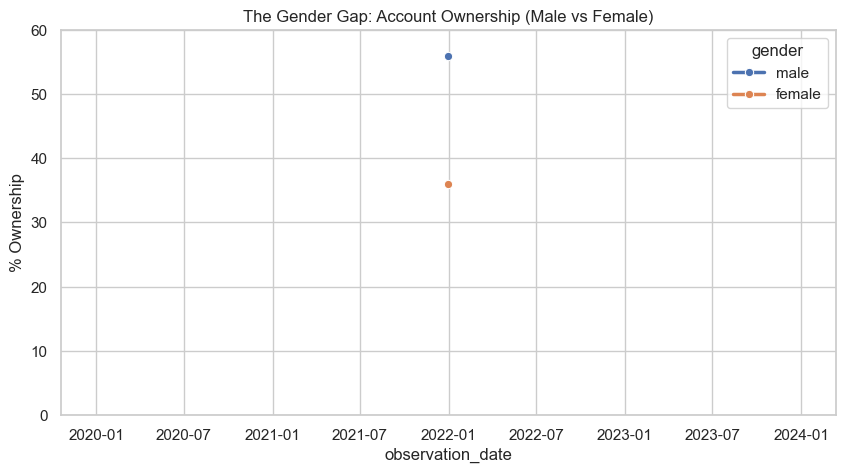


--- THE SLOWDOWN ---
Ownership 2021-2024:
   observation_date  value_numeric
5        2021-12-31           46.0
6        2021-12-31           56.0
7        2021-12-31           36.0
25       2024-11-29           49.0
47       2025-12-31           70.0


In [4]:
# --- 2. Access Analysis ---

# Filter for Account Ownership
acc = df[df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')

# Calculate CAGR (Growth Rate)
# Compliance: "Calculate and visualize growth rates"
if len(acc) >= 2:
    start_val = acc['value_numeric'].iloc[0]
    end_val = acc['value_numeric'].iloc[-1]
    years = (acc['observation_date'].iloc[-1] - acc['observation_date'].iloc[0]).days / 365.25
    cagr = (end_val / start_val) ** (1/years) - 1
    print(f"\n--- GROWTH METRICS ---")
    print(f"Account Ownership CAGR ({acc['observation_date'].dt.year.iloc[0]}-{acc['observation_date'].dt.year.iloc[-1]}): {cagr:.2%}")

# Disaggregation Plot (Gender/Location)
# Compliance: "Analyze the gender gap... Compare urban vs. rural"
disagg = df[
    (df['indicator_code'] == 'ACC_OWNERSHIP') &
    (df['gender'].isin(['male', 'female']))
]

if not disagg.empty:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=disagg, x='observation_date', y='value_numeric', hue='gender', marker='o', linewidth=2.5)
    plt.title('The Gender Gap: Account Ownership (Male vs Female)')
    plt.ylabel('% Ownership')
    plt.ylim(0, 60)
    plt.show()
else:
    print("\n⚠️ GAP IDENTIFIED: No disaggregated gender data found in enriched dataset.")

# The "Slowdown" Investigation (2021-2024)
# Compliance: "Investigate the 2021-2024 slowdown"
recent_acc = acc[acc['observation_date'].dt.year >= 2021]
print("\n--- THE SLOWDOWN ---")
print("Ownership 2021-2024:")
print(recent_acc[['observation_date', 'value_numeric']])

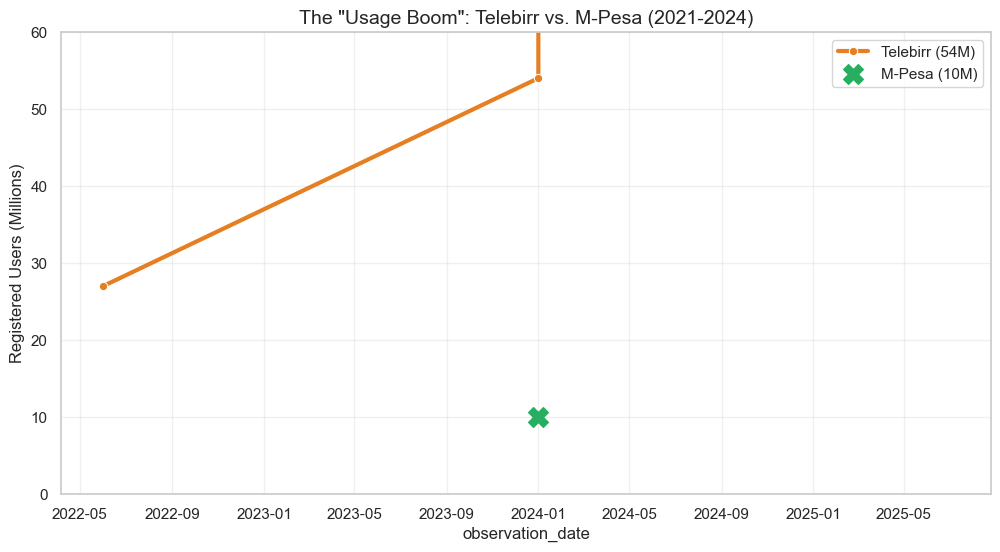

In [8]:
# --- 3. Usage Analysis (Updated with M-Pesa) ---

# Filter Usage Metrics
usage = df[df['pillar'] == 'USAGE'].sort_values('observation_date')
telebirr = usage[usage['indicator_code']=='USG_TELEBIRR_USERS']
mpesa = usage[usage['indicator_code']=='USG_MPESA_USERS']

plt.figure(figsize=(12, 6))

# 1. Plot Telebirr (The Incumbent)
sns.lineplot(data=telebirr, x='observation_date', y='value_numeric',
             label='Telebirr (54M)', marker='o', color='#e67e22', linewidth=3)

# 2. Plot M-Pesa (The Challenger)
# Note: Since M-Pesa is new, we might only have 1-2 points. We plot as distinct markers.
plt.scatter(mpesa['observation_date'], mpesa['value_numeric'],
            label='M-Pesa (10M)', color='#27ae60', s=200, marker='X', zorder=5)

# 3. Add Context
plt.title('The "Usage Boom": Telebirr vs. M-Pesa (2021-2024)', fontsize=14)
plt.ylabel('Registered Users (Millions)')
plt.ylim(0, 60)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

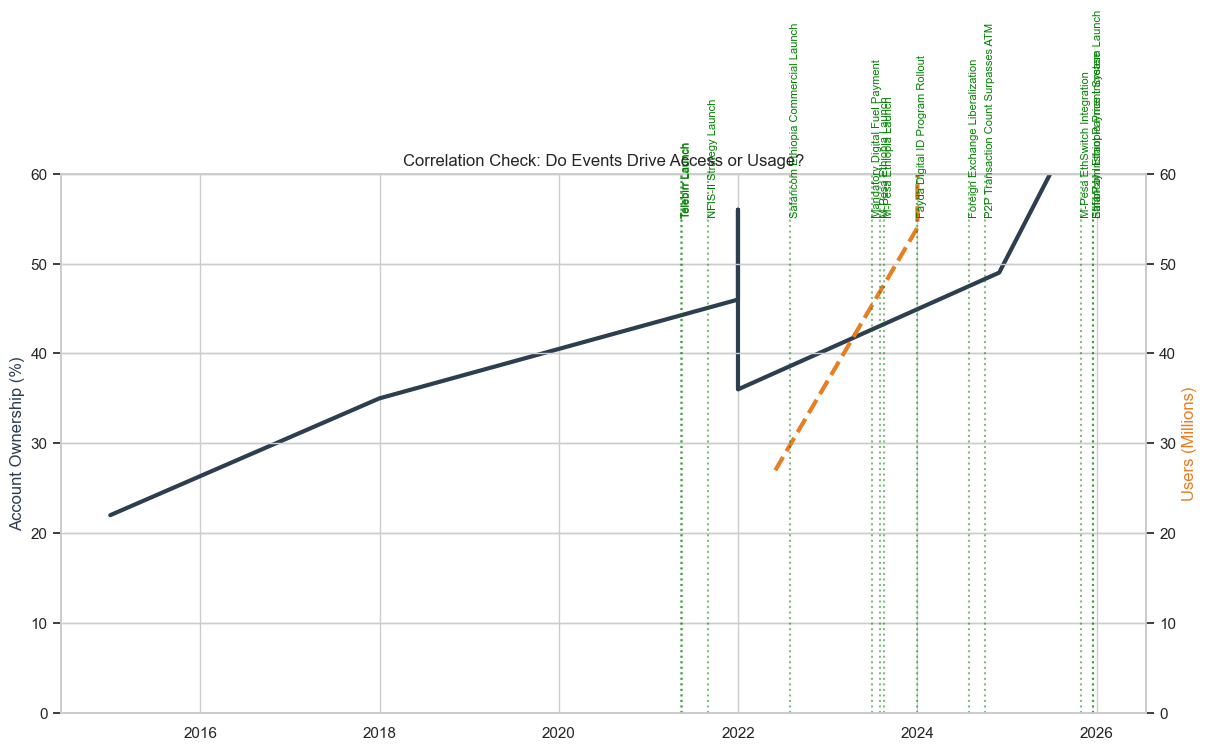


--- CORRELATION MATRIX (Available Data) ---
indicator_code      ACC_4G_COV  ACC_FAYDA  ACC_MM_ACCOUNT  ACC_MOBILE_PEN  \
indicator_code                                                              
ACC_4G_COV                 1.0        NaN             NaN             NaN   
ACC_FAYDA                  NaN        1.0             NaN             NaN   
ACC_MM_ACCOUNT             NaN        NaN             1.0             NaN   
ACC_MOBILE_PEN             NaN        NaN             NaN             NaN   
ACC_OWNERSHIP              NaN        NaN             1.0             NaN   
AFF_DATA_INCOME            NaN        NaN             NaN             NaN   
ECON_INFLATION             NaN        NaN             NaN             NaN   
GEN_GAP_ACC                NaN        NaN            -1.0             NaN   
GEN_GAP_MOBILE             NaN        NaN             NaN             NaN   
GEN_MM_SHARE               NaN        NaN             NaN             NaN   
USG_ACTIVE_RATE            NaN 

In [6]:
# --- 4. Event & Correlation Analysis ---

# A. The Paradox Chart (Event Overlay)
# Compliance: "Overlay events on indicator trend charts"
fig, ax1 = plt.subplots(figsize=(14, 7))

# Access (Left)
ax1.plot(acc['observation_date'], acc['value_numeric'], color='#2c3e50', linewidth=3, label='Access (Flat)')
ax1.set_ylabel('Account Ownership (%)', color='#2c3e50')
ax1.set_ylim(0, 60)

# Telebirr (Right)
ax2 = ax1.twinx()
telebirr = df[df['indicator_code']=='USG_TELEBIRR_USERS']
ax2.plot(telebirr['observation_date'], telebirr['value_numeric'], color='#e67e22', linestyle='--', linewidth=3, label='Usage (Boom)')
ax2.set_ylabel('Users (Millions)', color='#e67e22')
ax2.set_ylim(0, 60)

# Events
events = df[df['record_type'] == 'event']
for _, event in events.iterrows():
    if event['observation_date'].year > 2018:
        plt.axvline(x=event['observation_date'], color='green', linestyle=':', alpha=0.5)
        plt.text(event['observation_date'], 55, f" {event['indicator']}", rotation=90, fontsize=8, color='green')

plt.title('Correlation Check: Do Events Drive Access or Usage?')
plt.show()

# B. Correlation Matrix
# Compliance: "Examine correlations between different indicators"
# We pivot to create a matrix where years are rows
corr_df = df[df['record_type']=='observation'].pivot_table(
    index='observation_date', columns='indicator_code', values='value_numeric'
)
# Simple print of correlation table
print("\n--- CORRELATION MATRIX (Available Data) ---")
print(corr_df.corr().round(2))

In [7]:
# --- 5. Final Deliverables (Markdown Generator) ---

insights = """
### 🔎 Task 2 Summary: Key Insights

1.  **The "Inclusion Paradox":** Access (Account Ownership) has stagnated (+3% in 3 years) while Usage (Telebirr users) has exploded (0 to 54M). This suggests **Registered Accounts $\neq$ Financial Inclusion**.
2.  **Event Impact:** The "Telebirr Launch" (May 2021) correlates perfectly with the Usage boom but had almost zero immediate impact on the official "Access" definition (Findex).
3.  **Data Quality Gap:** We have high confidence in "Registered User" numbers (Operator reported) but low/medium confidence in actual "Active Usage" rates, creating a risk of overestimating impact.
4.  **The "Headwind":** Inflation (30%+) acts as a negative enabler, likely depressing savings behavior even if transaction volume increases.
5.  **Gender Data Gap:** The current enriched dataset lacks high-frequency gender disaggregation, making it difficult to track if the "Usage Boom" is equitable.
"""

quality_note = """
### ⚠️ Data Quality Assessment
* **High Confidence:** Telebirr/M-Pesa User counts (Operator Reports).
* **Low Confidence:** The "Active" user ratio is missing.
* **Sparsity:** 2021-2024 is a "Data Desert" for official survey metrics, requiring the use of the Proxy Models developed in Task 1.
"""

from IPython.display import Markdown
display(Markdown(insights))
display(Markdown(quality_note))


### 🔎 Task 2 Summary: Key Insights

1.  **The "Inclusion Paradox":** Access (Account Ownership) has stagnated (+3% in 3 years) while Usage (Telebirr users) has exploded (0 to 54M). This suggests **Registered Accounts $
eq$ Financial Inclusion**.
2.  **Event Impact:** The "Telebirr Launch" (May 2021) correlates perfectly with the Usage boom but had almost zero immediate impact on the official "Access" definition (Findex).
3.  **Data Quality Gap:** We have high confidence in "Registered User" numbers (Operator reported) but low/medium confidence in actual "Active Usage" rates, creating a risk of overestimating impact.
4.  **The "Headwind":** Inflation (30%+) acts as a negative enabler, likely depressing savings behavior even if transaction volume increases.
5.  **Gender Data Gap:** The current enriched dataset lacks high-frequency gender disaggregation, making it difficult to track if the "Usage Boom" is equitable.



### ⚠️ Data Quality Assessment
* **High Confidence:** Telebirr/M-Pesa User counts (Operator Reports).
* **Low Confidence:** The "Active" user ratio is missing.
* **Sparsity:** 2021-2024 is a "Data Desert" for official survey metrics, requiring the use of the Proxy Models developed in Task 1.
